# **Data Cleaning**

## Objectives

Clean data in preparation for determining the most important features.

## Inputs

1. House_prices_records.csv
2. Inherited_houses.csv

## Outputs

3. House_prices_records_clean.csv
4. Inherited_houses_clean.csv

## Comments
Note that this step is separate from feature engineering. We will need to do that after the correlation study in order to prepare the data for the model. We will using this opportunity to apply the same cleaning tools to the Inherited_houses.csv data set as we will need to do that before we can run them through the model.

---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing'

# Load Data

Section 1 content

In [4]:
import numpy as np
import pandas as pd

house_prices_df = pd.read_csv(f"outputs/datasets/collection/house_prices_records.csv")
inherited_houses_df = pd.read_csv(f"outputs/datasets/collection/inherited_houses.csv")

---

## Data cleaning

Following investigations the below cleaning strategy was implemented.


#### Remove columns missing substantial amounts of data.
EnclosedPorch and WoodDeckSF have 90.7% and 89.4% of the data missing. Where present it does not vary significantly across the range of the houses so will have limited predictive power. Imputing such a high proportion of missing data is a riskier option than removing these features entirely. 


In [5]:
from feature_engine.selection import DropFeatures

def drop_features(df):
    """
    Function to remove EnclosedPorch and WoodDeckSF from data set
    """
    imputer = DropFeatures(features_to_drop=['EnclosedPorch' , 'WoodDeckSF'])
    df_removed_columns = imputer.fit_transform(df)
    return df_removed_columns


In [6]:
# Apply drop_features function to house_prices_df and check columns have been removed.
# Should now have 22 columns rather than 24.
house_prices_df= drop_features(house_prices_df)
house_prices_df.shape

(1460, 22)

In [7]:
# Apply drop_features function to inherited_houses_df and check columns have been removed.
# Should now have 21 columns rather than 24.
inherited_houses_df = drop_features(inherited_houses_df)
inherited_houses_df.shape

(4, 21)

---

#### Impute Missing data for remaining columns.

Following removal of these two columns we can review the missing data. 

In [9]:
def EvaluateMissingData(df):
  """
  Function to evaluate data with missing values. 
  This function is taken from The code institute Churnometer walkthrough project.
  https://github.com/Code-Institute-Solutions/churnometer/blob/main/jupyter_notebooks/03%20-%20DataCleaning.ipynb
  """
  missing_data_absolute = df.isnull().sum()
  missing_data_percentage = round(missing_data_absolute/len(df)*100 , 2)
  df_missing_data = (pd.DataFrame(
                          data= {"RowsWithMissingData": missing_data_absolute,
                                 "PercentageOfDataset": missing_data_percentage,
                                 "DataType":df.dtypes}
                                  )
                    .sort_values(by=['PercentageOfDataset'],ascending=False)
                    .query("PercentageOfDataset > 0")
                    )

  return df_missing_data

df_missing_data = EvaluateMissingData(house_prices_df)
print(f"* There are {df_missing_data.shape[0]} variables with missing data \n")
df_missing_data

* There are 7 variables with missing data 



,RowsWithMissingData,PercentageOfDataset,DataType
LotFrontage,259,17.74,float64
GarageFinish,162,11.10,object
BsmtFinType1,114,7.81,object
BedroomAbvGr,99,6.78,float64
2ndFlrSF,86,5.89,float64
GarageYrBlt,81,5.55,float64
MasVnrArea,8,0.55,float64


In [11]:
rows_without_missing_data = house_prices_df.dropna()
rows_without_missing_data.shape[0]

797


We can see that there are still have seven columns missing data and 797 rows without missing data. This is a significant improvement but leaves nearly 40% of rows with missing data. We can see if this can be improved by experimenting with imputing the missing data. We will only need to impute missing data for the house_prices_df data set. We do not need to impute the inherited houses set.

To recapitulate we have alredy seen that factors related to measurements and dates are numeric and either positively or negatively skewed, whilst quality ratings are catagorical and evenly distributed. We will apply different methodologies to both and analyse the effects of the imputation.

* Batch 1 - LotFrontage, BedroomAbvGr, 2ndFlrSF, GarageYrBlt, MasVnrArea.
* Batch 2 - GarageFinish, BsmtFinType1.


In [15]:
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt

def DataCleaningEffect(df_original,df_cleaned,variables_applied_with_method):
  """
  Function to visualize data cleaning effect. This function is taken from the code institute Data Analysis 
  & Machine Learning Toolkit, Feature Engine Unit 9: Custom Functions. The function layers visualisations of 
  the data before and after imputations so we can see the difference.
  https://learn.codeinstitute.net/courses/course-v1:code_institute+CI_DA_ML+2021_Q4/courseware/1f851533cd6a4dcd8a280fd9f37ef4e2/bb0bf41fb8744b46813c0f52a74b9b11/
  """
  flag_count=1 # Indicate plot number
  
  # distinguish between numerical and categorical variables
  categorical_variables = df_original.select_dtypes(exclude=['number']).columns 

  # scan over variables, 
    # first on variables that you applied the method
    # if the variable is a numerical plot, a histogram if categorical plot a barplot
  for set_of_variables in [variables_applied_with_method]:
    print("\n=====================================================================================")
    print(f"* Distribution Effect Analysis After Data Cleaning Method in the following variables:")
    print(f"{set_of_variables} \n\n")
  

    for var in set_of_variables:
      if var in categorical_variables:  # it is categorical variable: barplot
        
        df1 = pd.DataFrame({"Type":"Original","Value":df_original[var]})
        df2 = pd.DataFrame({"Type":"Cleaned","Value":df_cleaned[var]})
        dfAux = pd.concat([df1, df2], axis=0)
        fig , axes = plt.subplots(figsize=(15, 5))
        sns.countplot(hue='Type', data=dfAux, x="Value",palette=['#432371',"#FAAE7B"])
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.xticks(rotation=90)
        plt.legend() 

      else: # it is numerical variable: histogram

        fig , axes = plt.subplots(figsize=(10, 5))
        sns.histplot(data=df_original, x=var, color="#432371", label='Original', kde=True,element="step", ax=axes)
        sns.histplot(data=df_cleaned, x=var, color="#FAAE7B", label='Cleaned', kde=True,element="step", ax=axes)
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.legend() 

      plt.show()
      flag_count+= 1

### Batch 1 - LotFrontage, BedroomAbvGr, 2ndFlrSF, GarageYrBlt, MasVnrArea.

As per the data inspection notebook, this data is numeric and either positively or negatively skewed. We will therefore use the median to impute the missing data.


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['LotFrontage', 'BedroomAbvGr', '2ndFlrSF', 'GarageYrBlt', 'MasVnrArea'] 




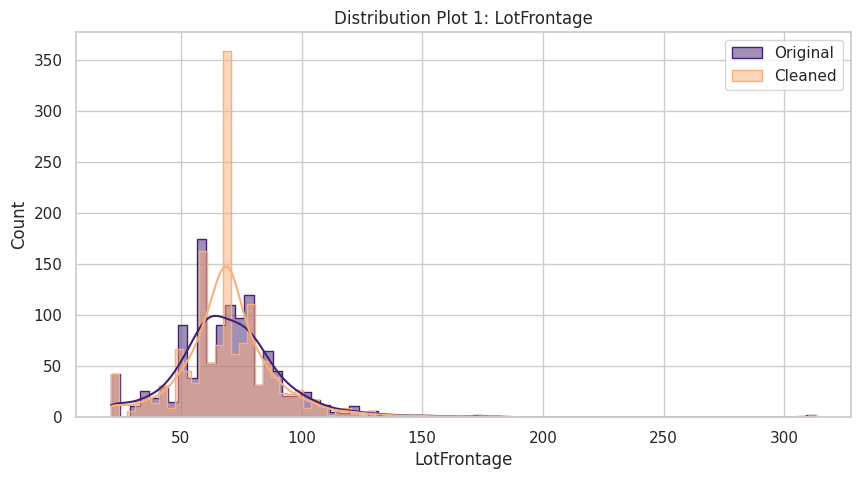

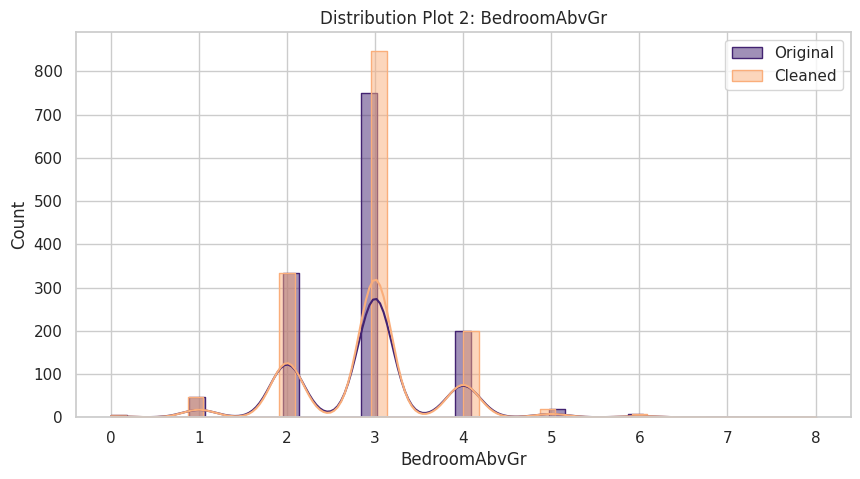

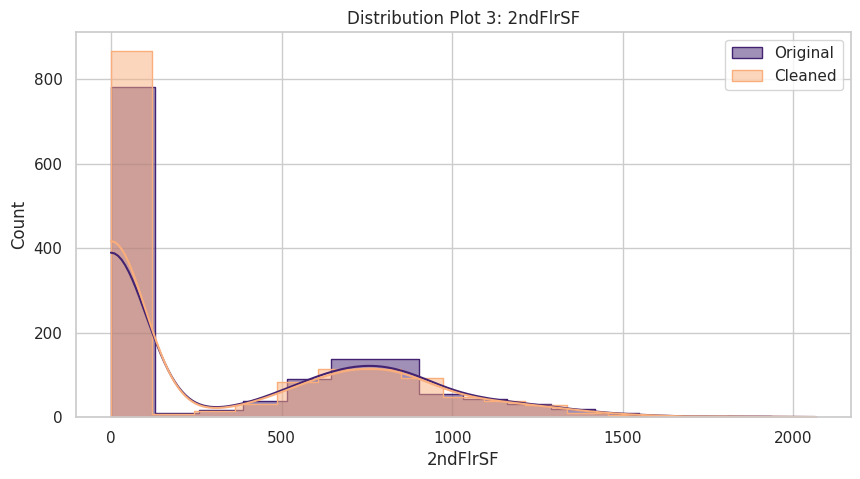

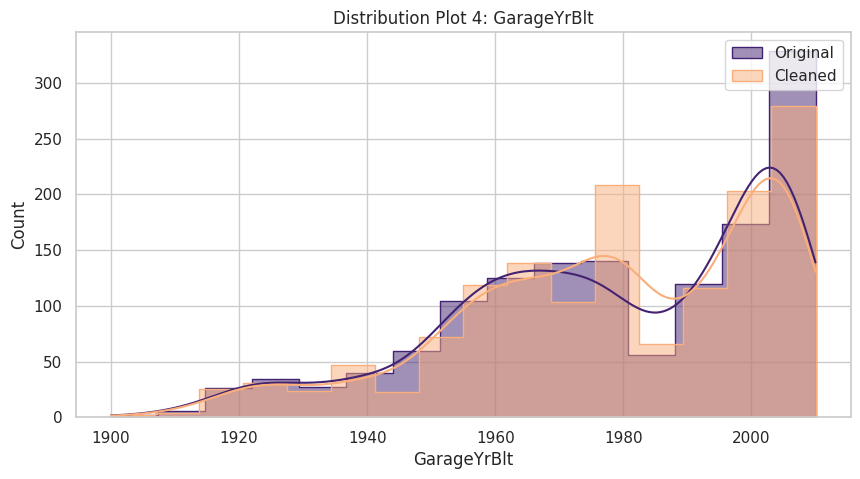

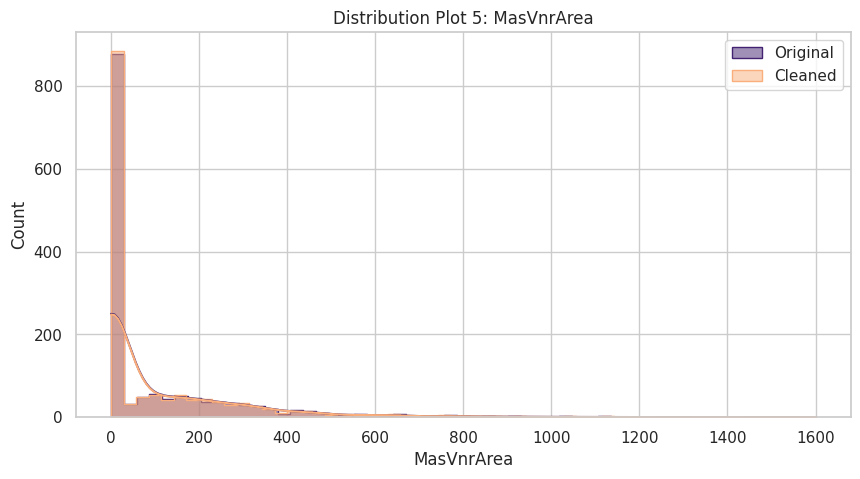

In [18]:
from feature_engine.imputation import MeanMedianImputer

variables_mean = ['LotFrontage' , 'BedroomAbvGr', '2ndFlrSF', 'GarageYrBlt', 'MasVnrArea']
imputer = MeanMedianImputer(imputation_method='median', variables=variables_mean)
df_method = imputer.fit_transform(house_prices_df)
DataCleaningEffect(df_original=house_prices_df,
                   df_cleaned=df_method,
                   variables_applied_with_method=variables_mean)

In reviewing this data we can observe the below. We can revisit these observations at a later stage if we need to.

1. LotFrontage - The imputation has added variables in the 60 - 70 raange, significantly affecting the range between the lowest and highest amount.
2. BedroomAbvGr - The imputation has added rooms in the 3 bedroom ranges.
3. 2ndFlrSF - The imputation has added missing data in both the 0 and the 500 - 100 range. This follows the trends 4.in the original data so is acceptable.
4. GarageYrBlt - There is some difference in the data between 1970 and 1980.
5. MasVnrArea - The cleaned and original data closely match.

---

# Push files to Repo

* Creating a new folder to save the cleaned data to.

In [ ]:
import os
try:
  os.makedirs(name='outputs/datasets/clean_data')
except Exception as e:
  print(e)

House_prices_records_test.to_csv(f"outputs/datasets/clean_data/House_prices_records_clean.csv",index=False)
Inherited_houses_clean.to_csv(f"outputs/datasets/clean_data/Inherited_houses_clean.csv",index=False)

